In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
df_neg_pi_mc = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/k0s/new/pbpb/neg_pi_eff_df_mc.parquet", engine="pyarrow") 
df_pos_pi_mc = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/k0s/new/pbpb/pos_pi_eff_df_mc.parquet", engine="pyarrow") 
df_neg_pi = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/k0s/new/pbpb/neg_pi_eff_df.parquet", engine="pyarrow") 
df_pos_pi = pd.read_parquet("/home/mdicosta/hf_pid_studies/distributions/k0s/new/pbpb/pos_pi_eff_df.parquet", engine="pyarrow") 

FileNotFoundError: [Errno 2] No such file or directory: '/home/mdicosta/hf_pid_studies/distributions/k0s/new/pbpb/neg_pi_eff_df_mc.parquet'

In [ ]:
df_neg_pi_mc

,fCentralityFT0C,fOccupancyFt0c,fPt,fNSigmaTpcPosPi,fNSigmaTpcPosPi_unc,fNSigmaTpcNegPi,fNSigmaTpcNegPi_unc,fNSigmaTofPosPi,fNSigmaTofPosPi_unc,fNSigmaTofNegPi,fNSigmaTofNegPi_unc
0,"[20, 30)","[0, 20000)","[0.0, 1.0)","[0.9469945091036275, 0.9245259090120652, 0.881...","[0.00016895834453178687, 0.0001992067148116874...","[0.9507747253840926, 0.9321403690360078, 0.897...","[0.00016314672968033558, 0.0001896670501841067...","[0.9971809038510207, 0.9544810093467511, 0.682...","[3.998410740776247e-05, 0.0001571901912558145,...","[0.9972502864877315, 0.954243857219633, 0.6833...","[3.9490378243948305e-05, 0.0001575795567126764..."


In [ ]:
def convert_to_interval(interval_str):
    match = re.match(r"(\[|\()(\d+(\.\d+)?),\s*(\d+(\.\d+)?)(\]|\))", interval_str)
    if match:
        # Extract the left and right bounds, converting them to float
        left = float(match.group(2))  # Group 2 captures the left bound
        right = float(match.group(4))  # Group 4 captures the right bound
        
        # Determine if the interval is closed on the left or right
        closed = 'left' if match.group(1) == '[' else 'right'
        # Return the interval as a pandas Interval
        return pd.Interval(left, right, closed=closed)
    
    # If the string doesn't match the interval format, return None
    return None  

def sort_df_by_interval(df, col):
    # Use .loc[] to safely modify the DataFrame and avoid the SettingWithCopyWarning
    df.loc[:, "lower_bound"] = df[col].apply(lambda x: x.left)  # Extract left bound
    df_sorted = df.sort_values("lower_bound").drop(columns="lower_bound")  # Sort and drop helper column
    return df_sorted

def get_label(diff_col_name):
    if diff_col_name == "fPt":
        return '$p_T$ (GeV/$c$)'
    if diff_col_name == "fOccupancyFt0c":
        return 'Occupancy FTOC (arb. units)'
    if diff_col_name == "fCentralityFT0C" or diff_col_name == "fCentralityFT0M":
        return 'Centrality'

In [ ]:
interval_cols = ['fCentralityFT0C', 'fOccupancyFt0c', 'fPt']

for col in interval_cols:
    df_neg_pi_mc[col] = df_neg_pi_mc[col].apply(convert_to_interval) 
    df_pos_pi_mc[col] = df_pos_pi_mc[col].apply(convert_to_interval) 
    df_neg_pi[col] = df_neg_pi[col].apply(convert_to_interval) 
    df_pos_pi[col] = df_pos_pi[col].apply(convert_to_interval)

TypeError: expected string or bytes-like object, got 'pandas._libs.interval.Interval'

In [ ]:
def draw_efficiencies(dfs_data, dfs_mc, leg_entries, diff_col_name, eff_var):
    
    colors = ['#800080', '#FFA500', '#00FFFF']
    
    sort_dfs_data, sort_dfs_mc = [], []
    for df_data, df_mc in zip(dfs_data, dfs_mc):
        sort_dfs_data.append(sort_df_by_interval(df_data, diff_col_name))
        sort_dfs_mc.append(sort_df_by_interval(df_mc, diff_col_name))
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 25))

    lower_bin_bounds = sort_dfs_data[0][diff_col_name].apply(lambda x: x.left)
    upper_bin_bounds = sort_dfs_data[0][diff_col_name].apply(lambda x: x.right)
    bin_centers = (np.array(lower_bin_bounds) + np.array(upper_bin_bounds)) / 2
    bin_widths = (np.array(upper_bin_bounds) - np.array(lower_bin_bounds)) / 2
    print(lower_bin_bounds)
    print(upper_bin_bounds)
    ticks = list(lower_bin_bounds) + [list(upper_bin_bounds)[-1]]
    for ax in axs.flat:
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks, rotation=45, ha='right')
    
    n_sigma_vals = [3,2,1]
    for icase, n_sigma in enumerate(n_sigma_vals):
        for idataset, (df_data, df_mc, leg_entry) in enumerate(zip(sort_dfs_data, sort_dfs_mc, leg_entries)):
            n_sigma_effs_data, n_sigma_effs_uncs_data, n_sigma_effs_mc, n_sigma_effs_uncs_mc = [], [], [], []
            for entry in range(len(df_data)):
                n_sigma_effs_data.append(df_data.loc[entry, eff_var][icase])
                n_sigma_effs_uncs_data.append(df_data.loc[entry, f"{eff_var}_unc"][icase])
                n_sigma_effs_mc.append(df_mc.loc[entry, eff_var][icase])
                n_sigma_effs_uncs_mc.append(df_mc.loc[entry, f"{eff_var}_unc"][icase])

            axs[icase, 0].errorbar(bin_centers, n_sigma_effs_data, yerr=n_sigma_effs_uncs_data, 
                        xerr=bin_widths, label=f'data, {leg_entry}', fmt='p', color=colors[idataset])
            axs[icase, 0].errorbar(bin_centers, n_sigma_effs_mc, yerr=n_sigma_effs_uncs_mc, 
                        xerr=bin_widths, label=f'mc, {leg_entry}', fmt='D', color=colors[idataset], markerfacecolor='none')

            axs[icase, 0].set_title(f"|{eff_var}| < {n_sigma}")
            axs[icase, 0].set_ylabel('Efficiency')
            # axs[icase, 0].set_ylim(min_eff.min()/2, 1.2)
            axs[icase, 0].set_xlabel(get_label(diff_col_name))
            axs[icase, 0].legend()
            axs[icase, 0].set_yscale('log')
            axs[icase, 0].grid(True)

            ratio = np.array(n_sigma_effs_data) / np.array(n_sigma_effs_mc)
            ratio_unc = ratio * np.sqrt((np.array(n_sigma_effs_uncs_data) / np.array(n_sigma_effs_data))**2 + (np.array(n_sigma_effs_uncs_mc) / np.array(n_sigma_effs_mc))**2)
            axs[icase, 1].errorbar(bin_centers, ratio, yerr=ratio_unc, xerr=bin_widths, label=leg_entry, fmt='o', color=colors[idataset])

            axs[icase, 1].set_title(f"Ratio |{eff_var}| < {n_sigma}")
            axs[icase, 1].set_xlabel(get_label(diff_col_name))
            axs[icase, 1].set_ylabel('Data / MC')
            # axs[icase, 1].set_ylim(min_ratio*0.95, max_ratio*1.05)
            axs[icase, 1].legend()
            axs[icase, 1].grid(True)

    # min_eff = 1
    # max_eff = 0
    # if np.array(effs).flatten()[np.array(effs).flatten()!=0].min() < min_eff:
    #     min_eff = np.array(effs).flatten()[np.array(effs).flatten()!=0].min()
    # if np.array(effs).flatten().max() > max_eff:
    #     max_eff = np.array(effs).flatten().max()

    # min_ratio = 1000
    # max_ratio = 0
    # if ratio[~np.isnan(ratio)].min() < min_ratio:
    #     min_ratio = ratio[~np.isnan(ratio)].min()
    # if ratio[~np.isnan(ratio)].max() > max_ratio:
    #     max_ratio = ratio[~np.isnan(ratio)].max()

    return fig

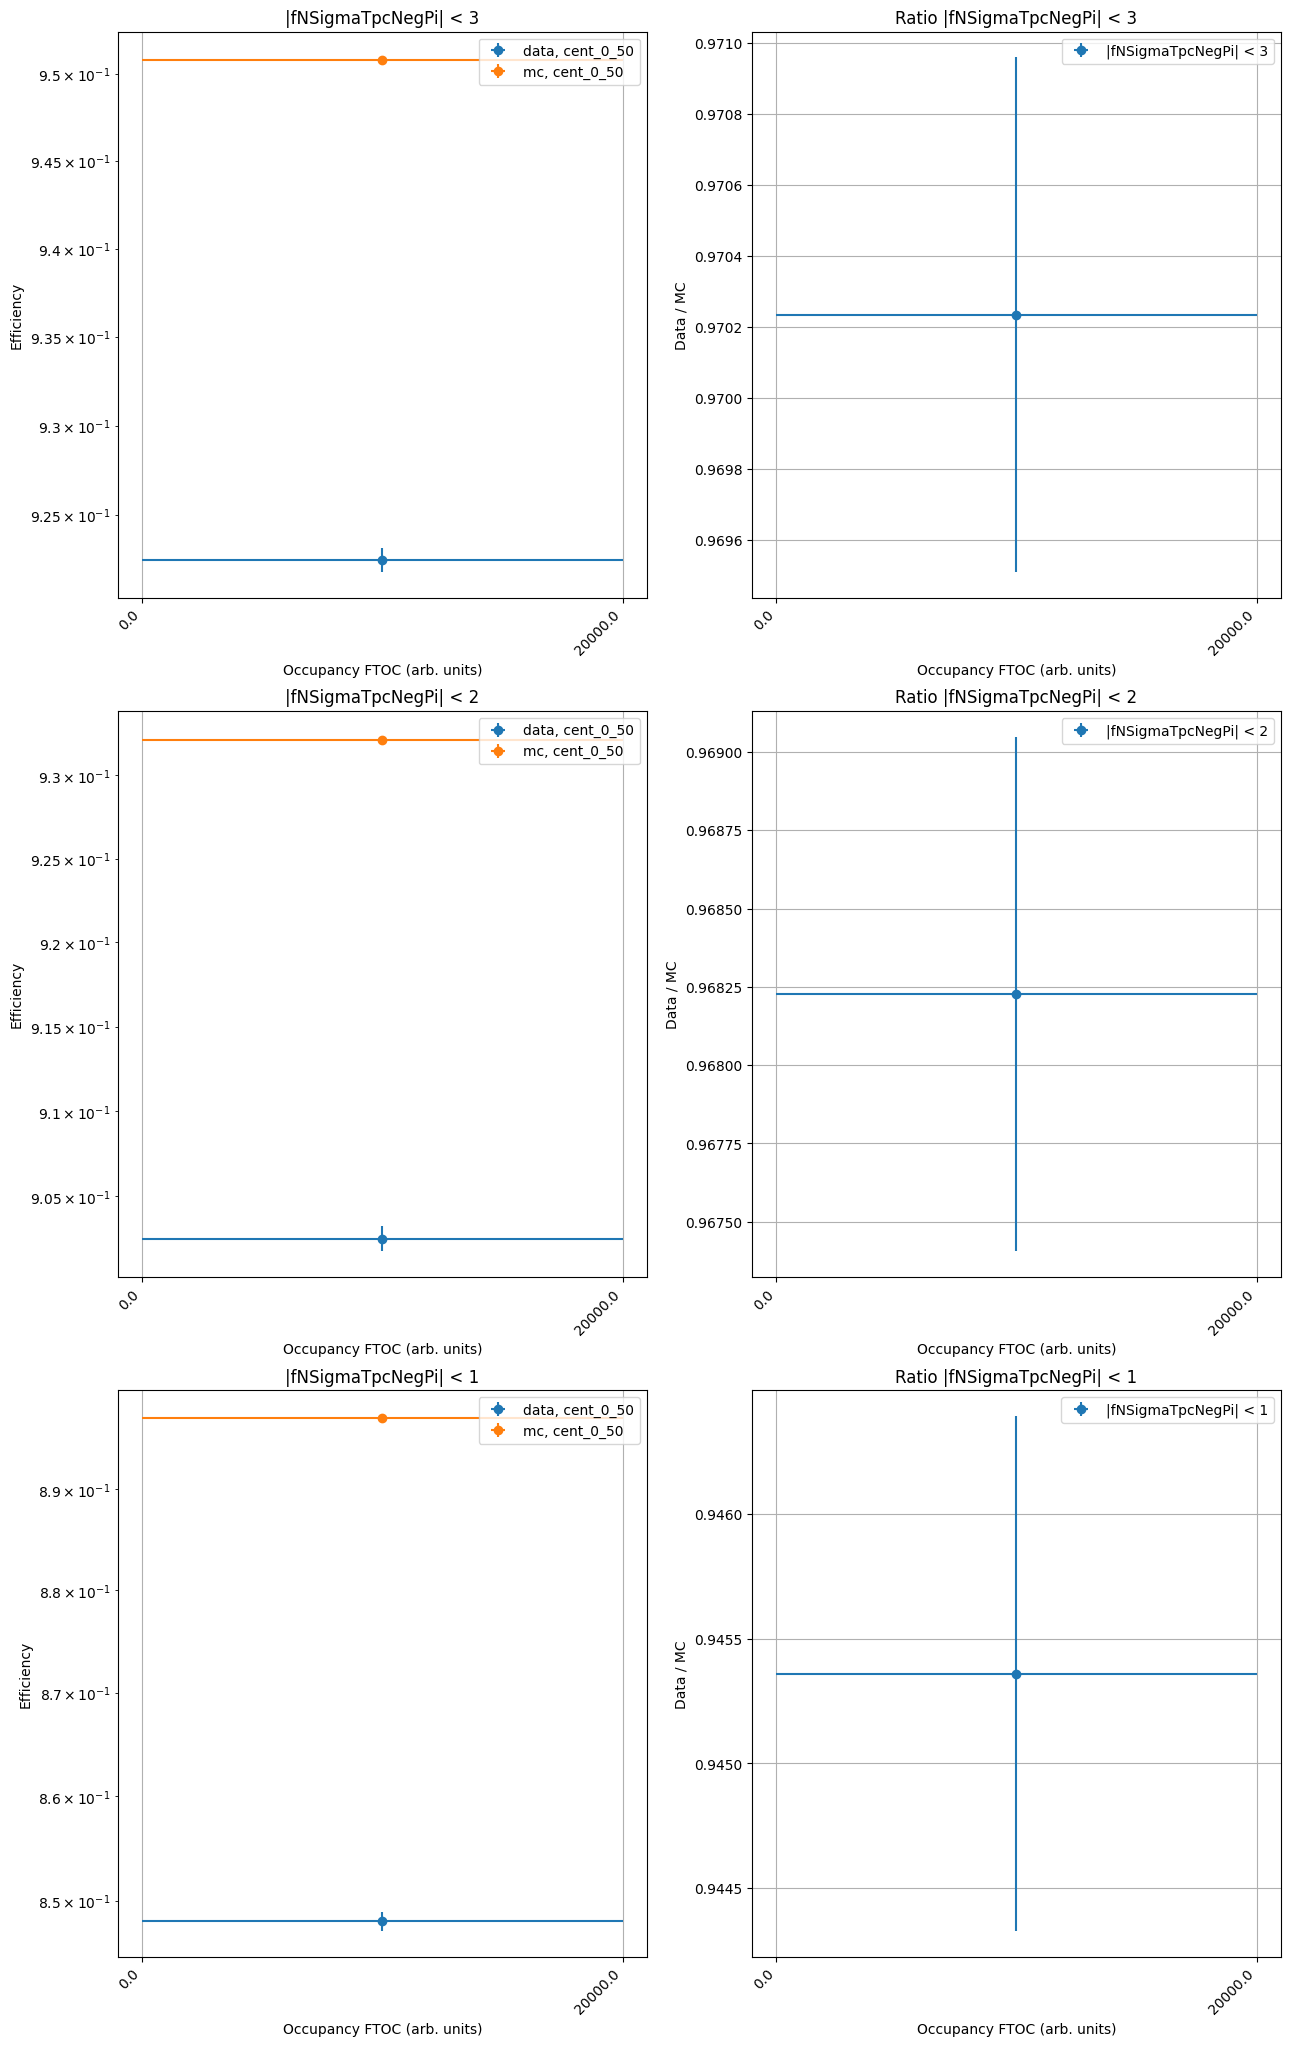

In [ ]:
cent_df_neg_pi_data = df_neg_pi.query('fCentralityFT0C == @pd.Interval(20., 30., closed="left")')
cent_df_neg_pi_mc = df_neg_pi_mc.query('fCentralityFT0C == @pd.Interval(20., 30., closed="left")')
fig_occ_neg_pi = draw_efficiencies([cent_df_neg_pi_data], [cent_df_neg_pi_mc], ['cent_0_50'], 'fOccupancyFt0c', 'fNSigmaTpcNegPi')

In [ ]:
occ_df_neg_pi_data

NameError: name 'occ_df_neg_pi_data' is not defined

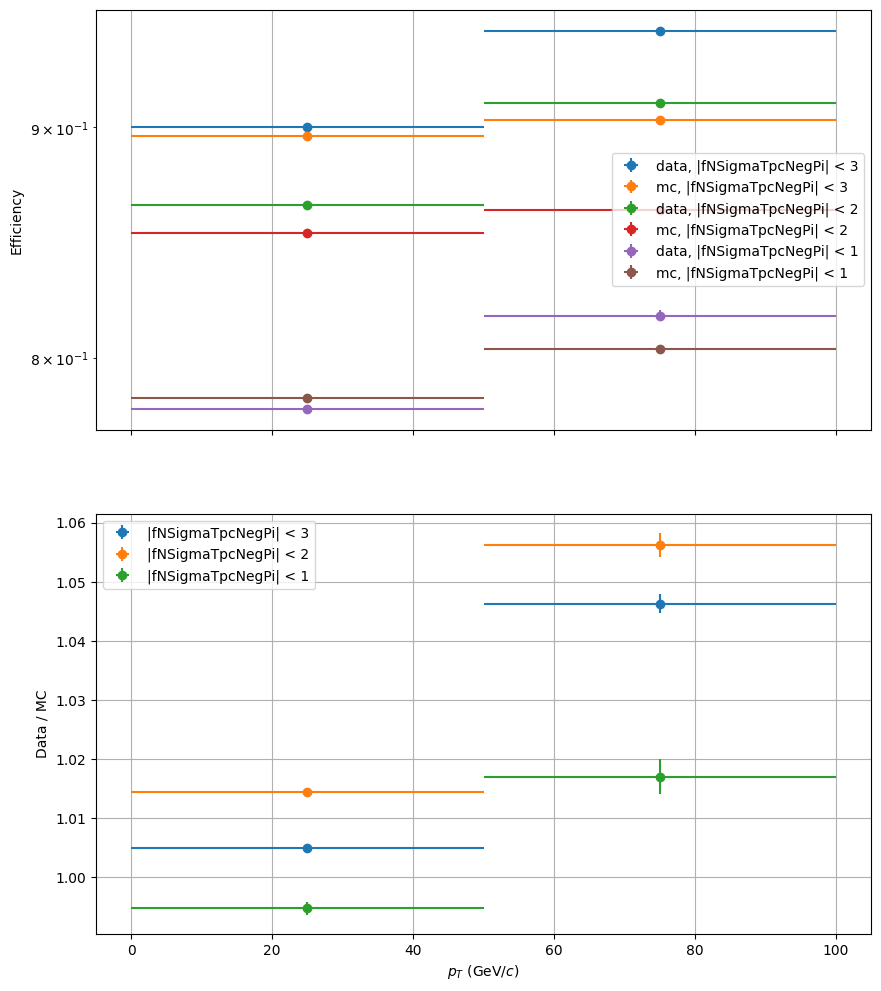

In [ ]:
occ_df_neg_pi_data = df_neg_pi.query('fOccupancyFt0c == @pd.Interval(0., 40000., closed="left")').reset_index(drop=True)
occ_df_neg_pi_mc = df_neg_pi_mc.query('fOccupancyFt0c == @pd.Interval(0., 40000., closed="left")').reset_index(drop=True)
fig_cent_neg_pi = draw_efficiencies(occ_df_neg_pi_data, occ_df_neg_pi_mc, 'fCentralityFT0C', 'fNSigmaTpcNegPi')